In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## variables

In [4]:
data_dir = "../../../data/02__mpra/02__activs"
human_max_f = "%s/human_TSS_vals.max_tile.txt" % data_dir
mouse_max_f = "%s/mouse_TSS_vals.max_tile.txt" % data_dir

In [5]:
results_dir = "../../../data/02__mpra/03__results"
results_f = "%s/native_cis_trans_effects_data.txt" % results_dir

In [6]:
motif_info_dir = "../../../misc/02__motif_info"
motif_map_f = "%s/00__lambert_et_al_files/00__metadata/curated_motif_map.txt" % motif_info_dir

In [7]:
motif_dir = "../../../data/04__mapped_motifs"
human_motifs_f = "%s/hg19_human_curated_tfs_out/fimo.txt.gz" % motif_dir
mouse_motifs_f = "%s/mm9_human_curated_tfs_out/fimo.txt.gz" % motif_dir

In [8]:
align_f = "../../../misc/00__tss_metadata/tss_map.seq_alignment.txt"

## 1. import data

In [9]:
results = pd.read_table(results_f, sep="\t")
print(len(results))
results.head()

3279


,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,trans_status_detail_human,fdr_trans_mouse,logFC_trans_mouse,abs_logFC_trans_mouse,trans_status_mouse,trans_status_detail_mouse,trans_status_one,trans_status_detail_one,logFC_trans_max,abs_logFC_trans_max
0,chr1,2985430,2985431,-,"chr1:2985420..2985438,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,no trans effect,0.585918,-0.384559,0.384559,no trans effect,no trans effect,no trans effect,no trans effect,-0.384559,0.384559
1,chr1,8086552,8086553,+,"chr1:8086546..8086571,+",div_lnc,ENSG00000238290.1,True,True,chr4,...,no trans effect,0.492102,0.500227,0.500227,no trans effect,no trans effect,no trans effect,no trans effect,1.300086,1.300086
2,chr1,26498322,26498323,-,"chr1:26498321..26498327,-",antisense_upep,ENSG00000236782.1,True,True,chr4,...,no trans effect,0.902393,-0.088485,0.088485,no trans effect,no trans effect,no trans effect,no trans effect,0.443366,0.443366
3,chr1,65533428,65533429,-,"chr1:65533390..65533443,-",intergenic,ENSG00000231485.1,True,True,chr4,...,no trans effect,0.311051,0.460589,0.460589,no trans effect,no trans effect,no trans effect,no trans effect,0.460589,0.460589
4,chr1,65533462,65533463,-,"chr1:65533457..65533465,-",intergenic,ENSG00000231485.1,True,True,chr4,...,no trans effect,0.375934,0.447387,0.447387,no trans effect,no trans effect,no trans effect,no trans effect,0.447387,0.447387


In [10]:
human_max = pd.read_table(human_max_f, sep="\t")
mouse_max = pd.read_table(mouse_max_f, sep="\t")
human_max.head()

,element,tss_id,biotype_hg19,tss_tile_num,HUES64,HUES64_log,HUES64_padj,HUES64_sig,cleaner_biotype
0,GCCCTCTCGCCCCGCCCTTGCCCAGGCAGCCCCCGGTCGCGACGGC...,h.999,div_pc,tile2,0.588526,-0.230235,1.848145e-02,sig,mRNA
1,GGGCGGGACGGAGACTCTGGGCTCAAGGCTCCTGGAAATGGGCGGG...,h.998,div_pc,tile2,0.885958,-0.052587,1.044316e-06,sig,mRNA
2,AAAAGGCAGTGCTTGATTCAATTCAACATTCACTGCGCCACTTACC...,h.997,div_pc,tile2,0.423129,-0.373527,2.996315e-01,not sig,mRNA
3,CGGAGGGGCGGGGCAAGAGTGGGAGGAGACCCTGCGCGCGGCCGCC...,h.996,div_pc,tile2,2.452145,0.389546,5.019212e-74,sig,mRNA
4,AGGGTGGTGCGTGGTCTACGGCGAGCGGAGTGGGGCGGGGTCGCGC...,h.995,div_pc,tile1,0.994045,-0.002594,6.400385e-09,sig,mRNA


In [11]:
motif_map = pd.read_table(motif_map_f)
motif_map.head()

,index,gene_id,gene_name
0,HKR1,ENSG00000181666,HKR1
1,M00117_1,ENSG00000137203,TFAP2A
2,M00118_1,ENSG00000137203,TFAP2A
3,M00119_1,ENSG00000137203,TFAP2A
4,M00120_1,ENSG00000137203,TFAP2A


In [12]:
human_motifs = pd.read_table(human_motifs_f, sep="\t")
human_motifs.head()

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence
0,ZNF212,HUMAN_EVO_TSS__h.3519__tile2;WT::chr7:47680526...,5,34,+,55.8485,7.500000e-19,2.850000e-13,gagagagagagagagagagagagagagaga
1,ZNF212,HUMAN_EVO_TSS__h.3519__tile2;WT::chr7:47680526...,7,36,+,55.8485,7.500000e-19,2.850000e-13,gagagagagagagagagagagagagagaga
2,ZNF212,HUMAN_EVO_TSS__h.3519__tile2;WT::chr7:47680526...,9,38,+,55.8485,7.500000e-19,2.850000e-13,gagagagagagagagagagagagagagaga
3,ZNF212,HUMAN_EVO_TSS__h.3519__tile2;WT::chr7:47680526...,11,40,+,55.8485,7.500000e-19,2.850000e-13,gagagagagagagagagagagagagagaga
4,ZNF212,HUMAN_EVO_TSS__h.357__tile2;WT::chr8:65285637-...,43,72,+,52.5051,5.310000e-18,1.150000e-12,gagagagagagagagagagaaagagagaga


In [13]:
mouse_motifs = pd.read_table(mouse_motifs_f, sep="\t")
mouse_motifs.head()

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence
0,ZNF212,MOUSE_EVO_TSS__m.2482__tile2;WT::chr4:9214553-...,1,30,+,55.8485,7.500000e-19,7.970000e-15,gagagagagagagagagagagagagagaga
1,ZNF212,MOUSE_EVO_TSS__m.2482__tile2;WT::chr4:9214553-...,3,32,+,55.8485,7.500000e-19,7.970000e-15,gagagagagagagagagagagagagagaga
2,ZNF212,MOUSE_EVO_TSS__m.2482__tile2;WT::chr4:9214553-...,5,34,+,55.8485,7.500000e-19,7.970000e-15,gagagagagagagagagagagagagagaga
3,ZNF212,MOUSE_EVO_TSS__m.315__tile1;WT::chr18:7003691-...,9,38,+,55.8485,7.500000e-19,7.970000e-15,gagagagagagagagagagagagagagaga
4,ZNF212,MOUSE_EVO_TSS__m.315__tile1;WT::chr18:7003691-...,11,40,+,55.8485,7.500000e-19,7.970000e-15,gagagagagagagagagagagagagagaga


In [14]:
align = pd.read_table(align_f)
align.head()

,hg19_id,mm9_id,seq_alignment_score,seq_alignment_string
0,h.2,m.1,255.0,-CCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCG...
1,h.3,m.2,158.6,-------------------------------------------CCG...
2,h.4,m.3,157.2,---AC--CAGGGC-TGAG-G--GAGG-CCCG-CC---CAGTACCTG...
3,h.5,m.4,148.3,----------------------------------------------...
4,h.6,m.4,200.7,--CA---TA------------CAC--A------------CACGCA-...


## 2. parse motif files

In [15]:
human_motifs = human_motifs.merge(motif_map, left_on="#pattern name", right_on="index", how="left")
human_motifs["hg19_id"] = human_motifs["sequence name"].str.split("__", expand=True)[1]
human_motifs["tile_num"] = human_motifs["sequence name"].str.split(";", expand=True)[0].str.split("__", expand=True)[2]
human_motifs["tss_strand"] = human_motifs["sequence name"].str[-2]
human_motifs.sample(5)

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence,index,gene_id,gene_name,hg19_id,tile_num,tss_strand
2718182,M00586_1,HUMAN_EVO_TSS__h.390__tile2;WT::chrX:134555763...,60,70,-,11.2857,0.000087,0.2970,CCACCCCCCCG,M00586_1,ENSG00000126603,GLIS2,h.390,tile2,+
652395,M06498_1,HUMAN_EVO_TSS__h.268__tile2;WT::chr4:16228057-...,121,131,+,13.4490,0.000012,0.0124,ccgccgccgcc,M06498_1,ENSG00000120738,EGR1,h.268,tile2,+
2069975,M07530_1,HUMAN_EVO_TSS__h.386__tile1;WT::chrX:110754758...,83,91,-,11.2653,0.000060,1.0000,GAGATAAGA,M07530_1,ENSG00000102145,GATA1,h.386,tile1,+
575717,M08998_1,HUMAN_EVO_TSS__h.3546__tile2;WT::chr18:3411813...,109,116,+,10.6429,0.000010,0.3940,GGGGTCAC,M08998_1,ENSG00000120798,NR2C1,h.3546,tile2,-
2491430,M02987_1,HUMAN_EVO_TSS__h.1637__tile1;WT::chr9:77114360...,99,108,-,11.0816,0.000077,0.0476,TGGGGGAGGG,M02987_1,ENSG00000164651,SP8,h.1637,tile1,-


In [16]:
mouse_motifs = mouse_motifs.merge(motif_map, left_on="#pattern name", right_on="index", how="left")
mouse_motifs["mm9_id"] = mouse_motifs["sequence name"].str.split("__", expand=True)[1]
mouse_motifs["tss_strand"] = mouse_motifs["sequence name"].str[-2]
mouse_motifs["tile_num"] = mouse_motifs["sequence name"].str.split(";", expand=True)[0].str.split("__", expand=True)[2]
mouse_motifs.sample(5)

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence,index,gene_id,gene_name,mm9_id,tss_strand,tile_num
1625667,M00561_1,MOUSE_EVO_TSS__m.2410__tile1;WT::chr11:1050424...,62,71,-,10.4228,0.000051,0.0819,CGCCCCCGAG,M00561_1,ENSG00000120738,EGR1,m.2410,-,tile1
341173,M08605_1,MOUSE_EVO_TSS__m.1655__tile2;WT::chr6:95668774...,32,44,-,14.6122,0.000006,0.0243,TCCGCCCCCTCCC,M08605_1,ENSG00000120738,EGR1,m.1655,+,tile2
617276,M05957_1,MOUSE_EVO_TSS__m.2323__tile2;WT::chr8:93393271...,11,24,+,12.2347,0.000013,0.2830,TGGCTCAAAGTTCA,M05957_1,ENSG00000160113,NR2F6,m.2323,+,tile2
1837076,M05274_1,MOUSE_EVO_TSS__m.2067__tile2;WT::chr12:5659297...,109,123,+,10.0816,0.000061,0.1140,ggcggcggagggcgg,M05274_1,ENSG00000102974,CTCF,m.2067,-,tile2
1557477,M09546_1,MOUSE_EVO_TSS__m.745__tile1;WT::chr7:29965659-...,94,104,-,11.7959,0.000048,0.1830,GAACGGAAGTC,M09546_1,ENSG00000126767,ELK1,m.745,-,tile1


In [17]:
# limit motif tiles to those that are max tiles (since we mapped motifs in both tiles)
human_max_motifs = human_max.merge(human_motifs, left_on=["tss_id", "tss_tile_num"],
                                   right_on=["hg19_id", "tile_num"], how="left").reset_index()
human_max_motifs = human_max_motifs[~pd.isnull(human_max_motifs["element"])]
human_max_motifs.head()

,level_0,element,tss_id,biotype_hg19,tss_tile_num,HUES64,HUES64_log,HUES64_padj,HUES64_sig,cleaner_biotype,...,score,p-value,q-value,matched sequence,index,gene_id,gene_name,hg19_id,tile_num,tss_strand
0,0,GCCCTCTCGCCCCGCCCTTGCCCAGGCAGCCCCCGGTCGCGACGGC...,h.999,div_pc,tile2,0.588526,-0.230235,0.018481,sig,mRNA,...,19.0367,9.940000e-08,0.000098,GGGCAAGGGCGGGGCGAGAG,M06783_1,ENSG00000185591,SP1,h.999,tile2,+
1,1,GCCCTCTCGCCCCGCCCTTGCCCAGGCAGCCCCCGGTCGCGACGGC...,h.999,div_pc,tile2,0.588526,-0.230235,0.018481,sig,mRNA,...,19.0367,2.410000e-07,0.000520,CCAGGGCCGCCGCCC,ZNF519,ENSG00000175322,ZNF519,h.999,tile2,+
2,2,GCCCTCTCGCCCCGCCCTTGCCCAGGCAGCCCCCGGTCGCGACGGC...,h.999,div_pc,tile2,0.588526,-0.230235,0.018481,sig,mRNA,...,18.2857,2.460000e-07,0.000586,GGGCAAGGGCGGGGC,M03053_1,ENSG00000185591,SP1,h.999,tile2,+
3,3,GCCCTCTCGCCCCGCCCTTGCCCAGGCAGCCCCCGGTCGCGACGGC...,h.999,div_pc,tile2,0.588526,-0.230235,0.018481,sig,mRNA,...,17.6429,2.860000e-07,0.000805,GGGGCAGGCGCGAGGAGCGGC,M10427_1,ENSG00000131061,ZNF341,h.999,tile2,+
4,4,GCCCTCTCGCCCCGCCCTTGCCCAGGCAGCCCCCGGTCGCGACGGC...,h.999,div_pc,tile2,0.588526,-0.230235,0.018481,sig,mRNA,...,18.1414,3.480000e-07,0.000311,GGGCAAGGGCGGGGCGAGAGG,M07126_1,ENSG00000181444,ZNF467,h.999,tile2,+


In [18]:
# limit motif tiles to those that are max tiles (since we mapped motifs in both tiles)
mouse_max_motifs = mouse_max.merge(mouse_motifs, left_on=["tss_id", "tss_tile_num"],
                                   right_on=["mm9_id", "tile_num"], how="left").reset_index()
mouse_max_motifs = mouse_max_motifs[~pd.isnull(mouse_max_motifs["element"])]
mouse_max_motifs.head()

,level_0,element,tss_id,biotype_mm9,tss_tile_num,mESC,mESC_log,mESC_padj,mESC_sig,cleaner_biotype,...,score,p-value,q-value,matched sequence,index,gene_id,gene_name,mm9_id,tss_strand,tile_num
0,0,GGGGGTTGGTGGCGGCGAGGTGGAGATGCTAGAAAAGGGCGGGACC...,m.999,div_pc,tile1,2.43217,0.385994,5.320842e-37,sig,mRNA,...,22.5918,3.220000e-09,0.00136,CGCCAAGATGGCGGC,M05478_1,ENSG00000100811,YY1,m.999,-,tile1
1,1,GGGGGTTGGTGGCGGCGAGGTGGAGATGCTAGAAAAGGGCGGGACC...,m.999,div_pc,tile1,2.43217,0.385994,5.320842e-37,sig,mRNA,...,21.9388,1.710000e-08,0.00208,CAAGATGGCGGCG,M05491_1,ENSG00000100811,YY1,m.999,-,tile1
2,2,GGGGGTTGGTGGCGGCGAGGTGGAGATGCTAGAAAAGGGCGGGACC...,m.999,div_pc,tile1,2.43217,0.385994,5.320842e-37,sig,mRNA,...,21.2347,2.040000e-08,0.00156,CAAGATGGCGGCGCT,M05355_1,ENSG00000100811,YY1,m.999,-,tile1
3,3,GGGGGTTGGTGGCGGCGAGGTGGAGATGCTAGAAAAGGGCGGGACC...,m.999,div_pc,tile1,2.43217,0.385994,5.320842e-37,sig,mRNA,...,21.5204,2.180000e-08,0.00109,CAAGATGGCGGCGCT,M05442_1,ENSG00000100811,YY1,m.999,-,tile1
4,4,GGGGGTTGGTGGCGGCGAGGTGGAGATGCTAGAAAAGGGCGGGACC...,m.999,div_pc,tile1,2.43217,0.385994,5.320842e-37,sig,mRNA,...,21.0510,2.340000e-08,0.00168,CAAGATGGCGGCGCT,M05321_1,ENSG00000100811,YY1,m.999,-,tile1


## 4. calculate % aligned sequence that overlaps motifs

In [19]:
motif_align_res = {}
for i, row in align.iterrows():
    if i % 50 == 0:
        print(i)
    hg19_id = row.hg19_id
    mm9_id = row.mm9_id
    seq_str = row.seq_alignment_string
    
    seq_str_human = seq_str.split("\n")[0]
    seq_str_align = seq_str.split("\n")[1]
    seq_str_mouse = seq_str.split("\n")[2]
    
    
    human_sig_motifs = human_max_motifs[human_max_motifs["q-value"] < 0.05]
    mouse_sig_motifs = mouse_max_motifs[mouse_max_motifs["q-value"] < 0.05]
    
    human_motifs = human_sig_motifs[human_sig_motifs["hg19_id"] == hg19_id][["start", "stop", "gene_name"]].drop_duplicates()
    mouse_motifs = mouse_sig_motifs[mouse_sig_motifs["mm9_id"] == mm9_id][["start", "stop", "gene_name"]].drop_duplicates()
    
    human_motif_starts = list(human_motifs["start"])
    human_motif_ends = list(human_motifs["stop"])
    
    mouse_motif_starts = list(mouse_motifs["start"])
    mouse_motif_ends = list(mouse_motifs["stop"])
    
    n_human_motifs = len(human_motif_starts)
    n_mouse_motifs = len(mouse_motif_starts)
    
    human_motif_ranges = [list(range(int(human_motif_starts[x]), int(human_motif_ends[x])+1)) for x in range(n_human_motifs)]
    mouse_motif_ranges = [list(range(int(mouse_motif_starts[x]), int(mouse_motif_ends[x])+1)) for x in range(n_mouse_motifs)]
    
    human_motif_ranges = [item for sublist in human_motif_ranges for item in sublist]
    mouse_motif_ranges = [item for sublist in mouse_motif_ranges for item in sublist]
    
    # first iterate through human sequence
    human_counter = 0
    human_coverage_list = []
    human_coverage_dict = {}
    for j, b in enumerate(seq_str_human):
        if b != "-":
            human_counter += 1
            cov_count = human_motif_ranges.count(human_counter)
            #print("b: %s, counter: %s, cov: %s" % (b, human_counter, cov_count))
            human_coverage_list.append(cov_count)
        else:
            if j == 0:
                cov_count = 0
        human_coverage_dict[j] = cov_count
    
    # then iterate through mouse sequence
    mouse_counter = 0
    mouse_coverage_list = []
    mouse_coverage_dict = {}
    for j, b in enumerate(seq_str_mouse):
        if b != "-":
            mouse_counter += 1
            cov_count = mouse_motif_ranges.count(mouse_counter)
            mouse_coverage_list.append(cov_count)
        else:
            if j == 0:
                cov_count = 0
        mouse_coverage_dict[j] = cov_count
                
    # then iterate through alignment
    n_align_w_motif = 0
    n_align_wo_motif = 0
    n_unalign_w_motif = 0
    n_unalign_wo_motif = 0
    for j, a in enumerate(seq_str_align):
        human_cov = human_coverage_dict[j]
        mouse_cov = mouse_coverage_dict[j]
        if a == "|":
            if human_cov > 0 or mouse_cov > 0:
                n_align_w_motif += 1
            else:
                n_align_wo_motif += 1
        else:
            if human_cov > 0 or mouse_cov > 0:
                n_unalign_w_motif += 1
            else:
                n_unalign_wo_motif += 1
                
    comp_id = "%s__%s" % (hg19_id, mm9_id)
    motif_align_res[comp_id] = {"n_align_w_motif": n_align_w_motif, "n_align_wo_motif": n_align_wo_motif,
                                "n_unalign_w_motif": n_unalign_w_motif, "n_unalign_wo_motif": n_unalign_wo_motif}

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250


In [20]:
len(motif_align_res)

3279

In [21]:
motif_align_res = pd.DataFrame.from_dict(motif_align_res, orient="index").reset_index()
motif_align_res.sample(5)

,index,n_align_w_motif,n_align_wo_motif,n_unalign_w_motif,n_unalign_wo_motif
1893,h.2943__m.2754,73,10,66,0
2950,h.652__m.538,98,0,87,3
1504,h.2530__m.2342,49,50,45,45
2835,h.526__m.412,100,4,73,6
2244,h.3292__m.3102,88,0,104,0


In [22]:
motif_align_res["perc_motif_regions_aligned"] = (motif_align_res["n_align_w_motif"]/(motif_align_res["n_align_w_motif"]+motif_align_res["n_unalign_w_motif"])) * 100
motif_align_res["perc_no_motif_regions_aligned"] = (motif_align_res["n_align_wo_motif"]/(motif_align_res["n_align_wo_motif"]+motif_align_res["n_unalign_wo_motif"])) * 100
motif_align_res.sort_values(by="perc_motif_regions_aligned").head()

,index,n_align_w_motif,n_align_wo_motif,n_unalign_w_motif,n_unalign_wo_motif,perc_motif_regions_aligned,perc_no_motif_regions_aligned
441,h.1436__m.1118,29,49,75,53,27.884615,48.039216
2116,h.3170__m.2981,54,14,129,15,29.508197,48.275862
241,h.1250__m.1122,20,65,47,70,29.850746,48.148148
2694,h.419__m.3505,16,71,35,69,31.372549,50.714286
551,h.1538__m.1350,67,0,145,0,31.603774,NaN


In [23]:
motif_align_res["hg19_id"] = motif_align_res["index"].str.split("__", expand=True)[0]
motif_align_res["mm9_id"] = motif_align_res["index"].str.split("__", expand=True)[1]
motif_align_res.sample(5)

,index,n_align_w_motif,n_align_wo_motif,n_unalign_w_motif,n_unalign_wo_motif,perc_motif_regions_aligned,perc_no_motif_regions_aligned,hg19_id,mm9_id
2592,h.3625__m.3427,95,0,63,18,60.126582,0.000000,h.3625,m.3427
3080,h.78__m.48,96,11,59,4,61.935484,73.333333,h.78,m.48
2628,h.3657__m.3508,97,1,87,5,52.717391,16.666667,h.3657,m.3508
3093,h.804__m.689,90,8,68,3,56.962025,72.727273,h.804,m.689
427,h.1423__m.1269,31,53,44,72,41.333333,42.400000,h.1423,m.1269


In [24]:
print(len(results))
motif_results = results.merge(motif_align_res, on=["hg19_id", "mm9_id"])
print(len(motif_results))
motif_results.head()

3279
3279


,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,trans_status_detail_one,logFC_trans_max,abs_logFC_trans_max,index,n_align_w_motif,n_align_wo_motif,n_unalign_w_motif,n_unalign_wo_motif,perc_motif_regions_aligned,perc_no_motif_regions_aligned
0,chr1,2985430,2985431,-,"chr1:2985420..2985438,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,no trans effect,-0.384559,0.384559,h.2__m.1,121,11,23,0,84.027778,100.0
1,chr1,8086552,8086553,+,"chr1:8086546..8086571,+",div_lnc,ENSG00000238290.1,True,True,chr4,...,no trans effect,1.300086,1.300086,h.3__m.2,88,0,79,22,52.694611,0.0
2,chr1,26498322,26498323,-,"chr1:26498321..26498327,-",antisense_upep,ENSG00000236782.1,True,True,chr4,...,no trans effect,0.443366,0.443366,h.4__m.3,91,2,92,3,49.726776,40.0
3,chr1,65533428,65533429,-,"chr1:65533390..65533443,-",intergenic,ENSG00000231485.1,True,True,chr4,...,no trans effect,0.460589,0.460589,h.5__m.4,75,0,68,1,52.447552,0.0
4,chr1,65533462,65533463,-,"chr1:65533457..65533465,-",intergenic,ENSG00000231485.1,True,True,chr4,...,no trans effect,0.447387,0.447387,h.6__m.4,104,1,43,0,70.748299,100.0


In [25]:
data_filt = motif_results[(motif_results["HUES64_padj_hg19"] < 0.05) | (motif_results["mESC_padj_mm9"] < 0.05)]
data_filt = data_filt[~data_filt["cis_status_detail_one"].str.contains("interaction")]
data_filt.drop_duplicates()
len(data_filt)

1831

In [26]:
data_filt.columns

Index(['chr_tss_hg19', 'start_tss_hg19', 'end_tss_hg19', 'strand_tss_hg19',
       'cage_id_hg19', 'biotype_hg19', 'name_peak_hg19', 'seq_orth',
       'cage_orth', 'chr_tss_mm9', 'start_tss_mm9', 'end_tss_mm9',
       'strand_tss_mm9', 'cage_id_mm9', 'biotype_mm9', 'name_peak_mm9',
       'avg_exp_hg19', 'avg_exp_mm9', 'stem_exp_hg19', 'stem_exp_mm9', 'har',
       'oligo_type', 'hg19_id', 'mm9_id', 'cleaner_biotype_hg19',
       'cleaner_biotype_mm9', 'biotype_switch', 'biotype_switch_clean',
       'hg19_element', 'mm9_element', 'HUES64_hg19', 'mESC_hg19',
       'HUES64_pval_hg19', 'mESC_pval_hg19', 'HUES64_padj_hg19',
       'mESC_padj_hg19', 'HUES64_mm9', 'mESC_mm9', 'HUES64_pval_mm9',
       'mESC_pval_mm9', 'HUES64_padj_mm9', 'mESC_padj_mm9', 'fdr_native',
       'logFC_native', 'abs_logFC_native', 'native_status',
       'native_status_detail', 'native_status_complete', 'fdr_cis_HUES64',
       'logFC_cis_HUES64', 'abs_logFC_cis_HUES64', 'cis_status_HUES64',
       'cis_status

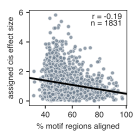

In [27]:
fig = plt.figure(figsize=(1.75, 1.75))
ax = sns.regplot(data=data_filt, x="perc_motif_regions_aligned", y="abs_logFC_cis_max", color="slategray", fit_reg=True,
                 scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, 
                 line_kws={"color": "black"})

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["perc_motif_regions_aligned"])) & 
                   (~pd.isnull(data_filt["abs_logFC_cis_max"]))]
r, p = spearmanr(no_nan["perc_motif_regions_aligned"], no_nan["abs_logFC_cis_max"])
ax.text(0.95, 0.97, "r = {:.2f}".format(r), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.95, 0.90, "n = %s" % (len(no_nan)), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
        
plt.xlabel("% motif regions aligned")
plt.ylabel("assigned cis effect size")
fig.savefig("cis_effect_v_motif_align.pdf", dpi="figure", bbox_inches="tight")

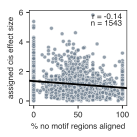

In [28]:
fig = plt.figure(figsize=(1.75, 1.75))
ax = sns.regplot(data=data_filt, x="perc_no_motif_regions_aligned", y="abs_logFC_cis_max", color="slategray", fit_reg=True,
                 scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, 
                 line_kws={"color": "black"})

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["perc_no_motif_regions_aligned"])) & 
                   (~pd.isnull(data_filt["abs_logFC_cis_max"]))]
r, p = spearmanr(no_nan["perc_no_motif_regions_aligned"], no_nan["abs_logFC_cis_max"])
ax.text(0.95, 0.97, "r = {:.2f}".format(r), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.95, 0.90, "n = %s" % (len(no_nan)), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
        
plt.xlabel("% no motif regions aligned")
plt.ylabel("assigned cis effect size")
fig.savefig("cis_effect_v_no_motif_align.pdf", dpi="figure", bbox_inches="tight")